In [1]:
FEEDS = {
    'polityka': [
        'https://www.tvp.pl/rss',
        'https://www.wprost.pl/rss',
        'https://www.dorzeczy.pl/rss',
        'https://www.fakt.pl/rss',
        'https://www.newsweek.pl/rss',
        'https://www.pb.pl/rss/najnowsze.xml',
        'https://www.computerworld.pl/rss',
        'https://www.spidersweb.pl/rss'
    ],
    'sport': [
        'https://sport.tvp.pl/rss',
        'https://sport.onet.pl/rss',
        'https://www.sport.pl/rss',
        'https://www.przegladsportowy.pl/rss',
        'https://www.polsatsport.pl/rss'
    ],
    'biznes': [
        'https://www.pb.pl/rss/najnowsze.xml',
        'https://www.forbes.pl/rss',
        'https://www.money.pl/rss',
        'https://www.parkiet.com/rss',
        'https://www.rp.pl/rss'
    ],
    'technologia': [
        'https://www.computerworld.pl/rss',
        'https://www.spidersweb.pl/rss',
        'https://www.dobreprogramy.pl/rss',
        'https://www.antyradio.pl/rss',
        'https://www.chip.pl/rss'
    ],
    'kultura': [
        'https://www.tvp.pl/rss',
        'https://www.onet.pl/rss',
        'https://www.wprost.pl/rss',
        'https://www.dorzeczy.pl/rss',
        'https://www.fakt.pl/rss'
    ],
    'zdrowie': [
        'https://www.medycyna24.pl/rss',
        'https://www.rynekzdrowia.pl/rss',
        'https://www.rynekaptek.pl/rss',
        'https://www.rynekfarmaceutyczny.pl/rss',
        'https://www.rynekzdrowia.pl/rss'
    ]
}

# RSS Scraper — Polska (PolsatNews)

Notebook do zebrania artykułów z kanałów RSS Polsat News i wygenerowania CSV z kolumnami `text` i `category` — przygotowane do analizy tematów (Topic Modeling): LDA i NMF.

Instrukcje: uruchom komórkę instalacyjną (pierwsza), a następnie uruchom komórki z funkcjami i przykładem modelowania.

In [ ]:
!pip install --quiet feedparser newspaper3k beautifulsoup4 pandas tqdm langdetect scikit-learn stop-words lxml

In [ ]:
import feedparser
import requests
from bs4 import BeautifulSoup
import pandas as pd
from newspaper import Article
from langdetect import detect, DetectorFactory
from stop_words import get_stop_words
from tqdm import tqdm
import time
import re
import logging

DetectorFactory.seed = 0
logging.getLogger('requests').setLevel(logging.WARNING)

In [ ]:
FEEDS = {
    'Polska': [
        'https://www.polsatnews.pl/rss/polska.xml',
        'https://tvn24.pl/polska.xml',
        'https://wiadomosci.wp.pl/rss.xml',
        'https://www.fakt.pl/rss',
        'https://dorzeczy.pl/rss',
        'https://www.wprost.pl/rss'
    ],
    'Świat': [
        'https://www.polsatnews.pl/rss/swiat.xml',
        'https://tvn24.pl/swiat.xml',
        'https://www.rmf24.pl/feed/',
        'https://www.newsweek.pl/rss'
    ],
    'Biznes': [
        'https://www.polsatnews.pl/rss/biznes.xml',
        'https://tvn24.pl/biznes.xml',
        'https://www.pb.pl/rss/najnowsze.xml'
    ],
    'Technologie': [
        'https://www.polsatnews.pl/rss/technologie.xml',
        'https://tvn24.pl/technologie.xml',
        'https://www.computerworld.pl/rss',
        'https://spidersweb.pl/rss'
    ],
    'Moto': [
        'https://www.polsatnews.pl/rss/moto.xml',
        'https://tvn24.pl/moto.xml'
    ],
    'Sport': [
        'https://www.polsatnews.pl/rss/sport.xml',
        'https://tvn24.pl/sport.xml',
        'https://sport.onet.pl/.feed'
    ],
}

In [ ]:
def extract_full_text(url, timeout=10, user_agent='Mozilla/5.0'):
    headers = {'User-Agent': user_agent}
    try:
        article = Article(url)
        article.download()
        article.parse()
        text = article.text
        if text and len(text) > 50:
            return text
    except Exception:
        pass

    try:
        resp = requests.get(url, headers=headers, timeout=timeout)
        if resp.status_code != 200:
            return None
        soup = BeautifulSoup(resp.content, 'lxml')
        selectors = ["article", "div[class*='article']", "div[class*='content']", "div[id*='article']"]
        for sel in selectors:
            el = soup.select_one(sel)
            if el:
                ps = el.find_all('p')
                text = '\n'.join([p.get_text(strip=True) for p in ps if p.get_text(strip=True)])
                if text and len(text) > 50:
                    return text
        ps = soup.find_all('p')
        text = '\n'.join([p.get_text(strip=True) for p in ps if p.get_text(strip=True)])
        if text and len(text) > 50:
            return text
    except Exception:
        return None
    return None


def clean_text(text):
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
def fetch_articles_from_feeds(feeds, max_articles_per_category=None, min_length=200, output_csv='polsatnews_articles.csv'):
    records = []
    seen_urls = set()
    for category, urls in feeds.items():
        if isinstance(urls, str):
            urls = [urls]
        category_entries = []
        for url in urls:
            print(f"Processing category: {category} -> {url}")
            fp = feedparser.parse(url)
            entries = fp.get('entries', [])
            category_entries.extend(entries)
        if max_articles_per_category:
            category_entries = category_entries[:max_articles_per_category]
        for entry in tqdm(category_entries, desc=f"Processing {category}"):
            link = entry.get('link') or entry.get('guid')
            if not link or link in seen_urls:
                continue
            title = entry.get('title', '')
            published = entry.get('published', entry.get('updated', None))
            summary = BeautifulSoup(entry.get('summary', ''), 'lxml').get_text(separator=' ', strip=True) if entry.get('summary') else ''
            time.sleep(0.2)
            text = extract_full_text(link)
            if not text:
                text = summary
            if not text:
                continue
            text = clean_text(text)
            if len(text) < min_length:
                continue
            try:
                lang = detect(text)
            except Exception:
                lang = ''
            if lang != 'pl':
                continue
            records.append({'category': category, 'title': title, 'url': link, 'published': published, 'text': text})
            seen_urls.add(link)

    df = pd.DataFrame(records)
    if df.empty:
        print('No articles found or all filtered out.')
        return df
    df.drop_duplicates(subset=['url', 'text'], inplace=True)
    df.to_csv(output_csv, index=False)
    print(f"Saved {len(df)} articles to {output_csv}")
    return df

In [ ]:
df = fetch_articles_from_feeds(FEEDS, min_length=50, output_csv='polsatnews_articles.csv')
df.info()

Processing category: Polska -> https://www.polsatnews.pl/rss/polska.xml
Processing category: Polska -> https://tvn24.pl/polska.xml
Processing category: Polska -> https://wiadomosci.wp.pl/rss.xml
Processing category: Polska -> https://www.fakt.pl/rss
Processing category: Polska -> https://dorzeczy.pl/rss
Processing category: Polska -> https://www.wprost.pl/rss


Processing Polska: 100%|██████████| 261/261 [01:43<00:00,  2.52it/s]


Processing category: Świat -> https://www.polsatnews.pl/rss/swiat.xml
Processing category: Świat -> https://tvn24.pl/swiat.xml
Processing category: Świat -> https://www.rmf24.pl/feed/
Processing category: Świat -> https://www.newsweek.pl/rss


Processing Świat: 100%|██████████| 95/95 [00:54<00:00,  1.76it/s]


Processing category: Biznes -> https://www.polsatnews.pl/rss/biznes.xml
Processing category: Biznes -> https://tvn24.pl/biznes.xml
Processing category: Biznes -> https://www.pb.pl/rss/najnowsze.xml


Processing Biznes: 100%|██████████| 110/110 [00:50<00:00,  2.17it/s]


Processing category: Technologie -> https://www.polsatnews.pl/rss/technologie.xml
Processing category: Technologie -> https://tvn24.pl/technologie.xml
Processing category: Technologie -> https://www.computerworld.pl/rss
Processing category: Technologie -> https://spidersweb.pl/rss


Processing Technologie: 100%|██████████| 120/120 [01:05<00:00,  1.83it/s]


Processing category: Moto -> https://www.polsatnews.pl/rss/moto.xml
Processing category: Moto -> https://tvn24.pl/moto.xml


Processing Moto: 100%|██████████| 50/50 [00:18<00:00,  2.77it/s]


Processing category: Sport -> https://www.polsatnews.pl/rss/sport.xml
Processing category: Sport -> https://tvn24.pl/sport.xml
Processing category: Sport -> https://sport.onet.pl/.feed


Processing Sport: 100%|██████████| 90/90 [00:35<00:00,  2.51it/s]

Saved 726 articles to polsatnews_articles.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   726 non-null    object
 1   title      726 non-null    object
 2   url        726 non-null    object
 3   published  726 non-null    object
 4   text       726 non-null    object
dtypes: object(5)
memory usage: 28.5+ KB


## Przykład: Topic Modeling — LDA i NMF (skrócony przykład)

Poniższy kod pokazuje how-to: wczytać CSV, wykonać wektoryzację (CountVectorizer / TfidfVectorizer) i dopasować LDA / NMF, a następnie wypisać najważniejsze słowa dla każdego tematu.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

import os
if 'df' not in globals() or df is None or df.empty:
    if os.path.exists('polsatnews_articles.csv'):
        df = pd.read_csv('polsatnews_articles.csv')

texts = df['text'].astype(str).tolist()

stop_words_pl = get_stop_words('polish')

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_pl, ngram_range=(1,2))
X_counts = vectorizer.fit_transform(texts)

n_topics = 8
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online')
lda.fit(X_counts)

def show_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}: ", ", ".join(top_features))

print('\nLDA topics:')
show_topics(lda, vectorizer.get_feature_names_out())

vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_pl, ngram_range=(1,2))
X_tfidf = vectorizer_tfidf.fit_transform(texts)
nmf = NMF(n_components=n_topics, random_state=42)
nmf.fit(X_tfidf)

print('\nNMF topics:')
show_topics(nmf, vectorizer_tfidf.get_feature_names_out())

/Users/mptb/Documents/Studia/Data_Science/2_sem/EDT/Project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(



LDA topics:
Topic 0:  świata, kobiet, grudnia, ziemi, miejsce, kraju, 2026, piątek, in, polska
Topic 1:  prezydent, usa, ukrainy, trump, rosji, prezydenta, putin, trumpa, ukrainie, powiedział
Topic 2:  zobacz, naszej, zdjęcie, stało, osób, ważnego, film, wrzutni, zdjęcie film, widziałeś
Topic 3:  meczu, 25, mecz, 00, polski, drużyny, drużyna, 20, 12, sport
Topic 4:  danych, treści, celu, pobieranie, dane, informacje, wyszukiwarki, web, zgody, względu
Topic 5:  ziobro, tablice, aktywów, sprawiedliwości, brukseli, tablic, rosji, rosyjskich, ukrainie, rosyjskich aktywów
Topic 6:  proc, zobacz, 2025, polsce, rynku, polska, danych, naszej, pracy, stało
Topic 7:  usb, uczniów, sprawdź ofertę, sprawdź, 16, ofertę, parkowania, gb, prezent, laptop


/Users/mptb/Documents/Studia/Data_Science/2_sem/EDT/Project/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['jeå', 'jä', 'li'] not in stop_words.
  warnings.warn(



NMF topics:
Topic 0:  zobacz, reklama, jazdy, ruchu, naszej, stało, ważnego, zdjęcie, wrzutni, film
Topic 1:  niniejszego, zawarte dane, muzyczne, zawarte, dane, względu, eksploracji wykorzystaną, dane formę, właściwe, właściwe przepisy
Topic 2:  proc, wzrost, pkt, cen, ujęciu, bank, ceny, inflacja, pkt proc, ujęciu rocznym
Topic 3:  usa, putin, ukrainy, trump, rosji, prezydent, ukrainie, trumpa, rosja, wojny
Topic 4:  danych, treści, pobieranie, web, celu, zautomatyzowaną metodą, polska sp, baz danych, zgody ringier, inteligencji ai
Topic 5:  zdrowia, sejmu, prezydenta, tusk, pis, ustawy, premier, prezydent, nfz, minister
Topic 6:  meczu, ligi, mecz, sport, polsat, polski, polsat sport, 25, drużyny, pucharu
Topic 7:  zus, emerytury, renty, świadczenie, świadczenia, emeryturę, wideo, pracy, emerytura, brutto


**Uwagi i wskazówki:**

- Jeśli chcesz pełnego zbiory artykułów, ustaw `max_articles_per_feed=None` i uruchom ponownie komórkę.
- Jeśli chcesz lepszej ekstrakcji treści, spróbuj skonfigurować `readability-lxml` lub przejrzeć selektory strony (np. `div[class*='article-body']`).
- CSV: `polsatnews_articles.csv` (kolumny: `category`, `title`, `url`, `published`, `text`).
- Do dalszej analizy tematycznej warto przygotować tokenizację i lematyzację (np. `spaCy` z modelem polskim, `pl_core_news_sm`).

In [ ]:
!pip install --quiet lxml_html_clean

In [ ]:
df_sample = fetch_articles_from_feeds(FEEDS, max_articles_per_category=10, min_length=100, output_csv='polsatnews_sample.csv')
print('\nSample fetch result:')
df_sample.head()

Processing category: Polska -> https://www.polsatnews.pl/rss/polska.xml
Processing category: Polska -> https://tvn24.pl/polska.xml
Processing category: Polska -> https://wiadomosci.wp.pl/rss.xml
Processing category: Polska -> https://www.fakt.pl/rss
Processing category: Polska -> https://dorzeczy.pl/rss
Processing category: Polska -> https://www.wprost.pl/rss


Processing Polska: 100%|██████████| 10/10 [00:03<00:00,  2.64it/s]


Processing category: Świat -> https://www.polsatnews.pl/rss/swiat.xml
Processing category: Świat -> https://tvn24.pl/swiat.xml
Processing category: Świat -> https://www.rmf24.pl/feed/
Processing category: Świat -> https://www.newsweek.pl/rss


Processing Świat: 100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


Processing category: Biznes -> https://www.polsatnews.pl/rss/biznes.xml
Processing category: Biznes -> https://tvn24.pl/biznes.xml
Processing category: Biznes -> https://www.pb.pl/rss/najnowsze.xml


Processing Biznes: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Processing category: Technologie -> https://www.polsatnews.pl/rss/technologie.xml
Processing category: Technologie -> https://tvn24.pl/technologie.xml
Processing category: Technologie -> https://www.computerworld.pl/rss
Processing category: Technologie -> https://spidersweb.pl/rss


Processing Technologie: 100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


Processing category: Moto -> https://www.polsatnews.pl/rss/moto.xml
Processing category: Moto -> https://tvn24.pl/moto.xml


Processing Moto: 100%|██████████| 10/10 [00:03<00:00,  2.83it/s]


Processing category: Sport -> https://www.polsatnews.pl/rss/sport.xml
Processing category: Sport -> https://tvn24.pl/sport.xml
Processing category: Sport -> https://sport.onet.pl/.feed


Processing Sport: 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

Saved 60 articles to polsatnews_sample.csv

Sample fetch result:


,category,title,url,published,text
0,Polska,"""Efekt, a nie liczba świadczeń"". Prof. Jarosła...",https://www.polsatnews.pl/wiadomosc/2025-12-04...,"Thu, 04 Dec 2025 19:56:00 +0100","Fedorowski stwierdził, że polskie szpitale pot..."
1,Polska,Sejm zdecyduje ws. weta prezydenta. Marszałek ...,https://www.polsatnews.pl/wiadomosc/2025-12-04...,"Thu, 04 Dec 2025 18:12:00 +0100",W rozmowie z dziennikarzami marszałek Sejmu Wł...
2,Polska,Mglista noc. IMGW wydało ostrzeżenia dla 13 wo...,https://www.polsatnews.pl/wiadomosc/2025-12-04...,"Thu, 04 Dec 2025 19:17:00 +0100",Instytut Meteorologii i Gospodarki Wodnej wyda...
3,Polska,"""Ksenofobiczny nauczyciel"" i pobicie ukraiński...",https://www.polsatnews.pl/wiadomosc/2025-12-04...,"Thu, 04 Dec 2025 18:56:00 +0100",Sprawa - którą opisał portal Onet - dotyczy uc...
4,Polska,Nie żyje jeden z najbogatszych Polaków. Leszek...,https://www.polsatnews.pl/wiadomosc/2025-12-04...,"Thu, 04 Dec 2025 16:15:00 +0100","O śmierci Leszka Gierszewskiego, jednego z naj..."


In [ ]:
import os
if 'df' not in globals() or df is None: 
    if os.path.exists('polsatnews_sample.csv'):
        df = pd.read_csv('polsatnews_sample.csv')
    elif os.path.exists('polsatnews_articles.csv'):
        df = pd.read_csv('polsatnews_articles.csv')
    else:
        df = df_sample if 'df_sample' in globals() else pd.DataFrame()

print('Articles loaded:', len(df))

Articles loaded: 726


In [ ]:
%pip install --quiet gensim spacy pyldavis matplotlib seaborn nltk

import sys
try:
    import pl_core_news_sm
except Exception:
    print('Downloading spacy pl_core_news_sm model. This may take a while...')
    !python -m spacy download pl_core_news_sm

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 2.6 MB/s  0:00:07 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('pl_core_news_sm')


In [ ]:
import re
import unicodedata
from collections import Counter

try:
    import spacy
    nlp = spacy.load('pl_core_news_sm')
except Exception as e:
    nlp = None

polish_stopwords = set(get_stop_words('polish'))

if nlp is not None:
    polish_stopwords |= set([w for w in nlp.Defaults.stop_words])

extra_stops = {'z', 'na', 'i', 'w', 'o', 'że', 'się', 'roku', 'r', 'godz', 'dnia', 'fot', 'foto', 'zdjęcie', 'więcej', 'czytaj'}
polish_stopwords |= extra_stops

RE_URL = re.compile(r'https?://\S+|www\.\S+')
RE_NON_LETTER = re.compile(r'[^a-zA-ZąćęłńóśżźĄĆĘŁŃÓŚŻŹ\s-]')
RE_MULTI_WS = re.compile(r'\s+')


def normalize_text(text):
    if not isinstance(text, str):
        return ''
    text = text.strip()
    text = RE_URL.sub(' ', text)
    text = text.replace('\xa0', ' ')
    text = RE_NON_LETTER.sub(' ', text)
    text = RE_MULTI_WS.sub(' ', text)
    text = text.lower()
    return text


def lemmatize_and_tokenize(text, nlp_model=None, stopwords=None, min_token_len=3, keep_numbers=False):
    text_norm = normalize_text(text)
    if nlp_model is None:
        tokens = [t for t in text_norm.split() if len(t) >= min_token_len and (keep_numbers or not t.isdigit())]
        if stopwords:
            tokens = [t for t in tokens if t not in stopwords]
        return tokens

    doc = nlp_model(text_norm)
    tokens = []
    for tok in doc:
        if tok.is_space or tok.is_punct:
            continue
        lemma = tok.lemma_.lower().strip()
        if len(lemma) < min_token_len:
            continue
        if stopwords and lemma in stopwords:
            continue
        if not keep_numbers and lemma.isdigit():
            continue
        tokens.append(lemma)
    return tokens


def preprocess_text(text, nlp_model=nlp, stopwords=polish_stopwords, min_token_len=3):
    tokens = lemmatize_and_tokenize(text, nlp_model=nlp_model, stopwords=stopwords, min_token_len=min_token_len)
    return ' '.join(tokens), tokens

In [ ]:
def prepare_dataset(df_in, text_col='text', min_tokens=30, output_csv='polsatnews_articles_clean.csv', nlp_model=nlp, stopwords=polish_stopwords):
    df_local = df_in.copy()
    df_local['text_norm'], df_local['tokens'] = zip(*df_local[text_col].apply(lambda t: preprocess_text(t, nlp_model=nlp_model, stopwords=stopwords)))
    df_local['n_tokens'] = df_local['tokens'].apply(len)
    df_local = df_local[df_local['n_tokens'] >= min_tokens].reset_index(drop=True)
    df_local.drop_duplicates(subset=['text_norm'], inplace=True)
    df_local.to_csv(output_csv, index=False)
    print(f"Prepared dataset: {len(df_local)} articles saved to {output_csv}")
    return df_local


if 'df' in globals() and not df.empty:
    df_clean = prepare_dataset(df, min_tokens=30, output_csv='polsatnews_articles_clean.csv')
    if 'texts_tokens' not in globals():
        try:
            texts_tokens = df_clean['tokens'].tolist()
        except Exception:
            texts_tokens = []
else:
    print('No data loaded to prepare')

Prepared dataset: 712 articles saved to polsatnews_articles_clean.csv


Dictionary size: 4318
num_topics=2, coherence=0.3041
num_topics=3, coherence=0.3178
num_topics=4, coherence=0.3190
num_topics=5, coherence=0.3133
num_topics=6, coherence=0.3444
num_topics=7, coherence=0.3444
num_topics=8, coherence=0.3708
num_topics=9, coherence=0.3669
num_topics=10, coherence=0.4109
num_topics=11, coherence=0.3882
num_topics=12, coherence=0.4023


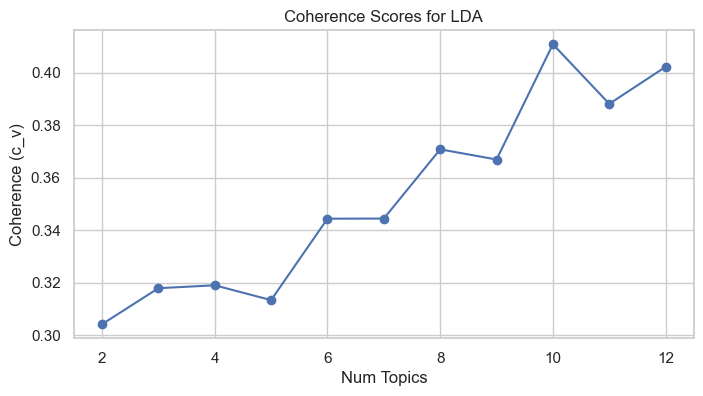

Best num topics (gensim LDA): 10
Topic 0: 0.007*"mecz" + 0.007*"polski" + 0.006*"polska" + 0.006*"pierwszy" + 0.006*"złoty" + 0.006*"dobry" + 0.006*"miejsce" + 0.005*"drużyna" + 0.005*"świat" + 0.005*"ostatni"
Topic 1: 0.009*"prezydent" + 0.008*"ustawa" + 0.008*"sprawa" + 0.006*"sejm" + 0.005*"dotyczyć" + 0.005*"mówić" + 0.004*"informacja" + 0.004*"decyzja" + 0.004*"minister" + 0.004*"swój"
Topic 2: 0.008*"dane" + 0.007*"system" + 0.007*"firma" + 0.006*"zdrowie" + 0.004*"nowy" + 0.004*"polski" + 0.004*"duży" + 0.004*"polska" + 0.004*"praca" + 0.003*"zmiana"
Topic 3: 0.007*"czas" + 0.007*"system" + 0.006*"nowy" + 0.006*"polski" + 0.005*"reklama" + 0.005*"polska" + 0.004*"samolot" + 0.004*"urządzenie" + 0.004*"droga" + 0.004*"ładowanie"
Topic 4: 0.007*"rosja" + 0.007*"rosyjski" + 0.006*"dziecko" + 0.005*"miliard" + 0.005*"putin" + 0.004*"spotkanie" + 0.004*"prezydent" + 0.004*"polska" + 0.004*"ukraina" + 0.004*"złoty"
Topic 5: 0.015*"ukraina" + 0.012*"prezydent" + 0.011*"rosja" + 0.009*"

In [ ]:
import gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns

if 'texts_tokens_bigrams' in globals():
    texts_tokens_used = texts_tokens_bigrams
elif 'texts_tokens' in globals():
    texts_tokens_used = texts_tokens
elif 'df_clean' in globals() and not df_clean.empty:
    if 'tokens_clean' in df_clean.columns:
        texts_tokens_used = df_clean['tokens_clean'].tolist()
    else:
        texts_tokens_used = df_clean['tokens'].tolist()
else:
    texts_tokens_used = []

try:
    dictionary
except NameError:
    dictionary = Dictionary(texts_tokens_used)
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=50000)
    corpus = [dictionary.doc2bow(text) for text in texts_tokens_used]

print('Dictionary size:', len(dictionary))

def compute_coherence_values(tokenized_texts, start=2, limit=15, step=1, passes=5, random_state=42):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit + 1, step):
        model = gensim.models.LdaModel(corpus=[dictionary.doc2bow(text) for text in tokenized_texts],
                                       id2word=dictionary, num_topics=num_topics, passes=passes, random_state=random_state)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=tokenized_texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f'num_topics={num_topics}, coherence={coherence_values[-1]:.4f}')
    return model_list, coherence_values

start, limit, step = 2, 12, 1
models, coherences = compute_coherence_values(texts_tokens_used, start=start, limit=limit, step=step)

sns.set(style='whitegrid')
plt.figure(figsize=(8, 4))
plt.plot(range(start, limit + 1, step), coherences, marker='o')
plt.xlabel('Num Topics')
plt.ylabel('Coherence (c_v)')
plt.title('Coherence Scores for LDA')
plt.show()

best_idx = int(coherences.index(max(coherences)))
best_model = models[best_idx]
best_n = start + best_idx * step
print('Best num topics (gensim LDA):', best_n)

def show_gensim_topics(model, num_words=10):
    for idx, topic in model.print_topics(num_words=num_words):
        print(f"Topic {idx}: {topic}")

show_gensim_topics(best_model)

def get_document_topics(model, bow_corpus):
    doc_topics = [sorted(model.get_document_topics(bow), key=lambda x: -x[1]) for bow in bow_corpus]
    dominant_topic = [t[0][0] if t and len(t) > 0 else -1 for t in doc_topics]
    dominant_prob = [t[0][1] if t and len(t) > 0 else 0.0 for t in doc_topics]
    return dominant_topic, dominant_prob

best_doc_topics, best_doc_probs = get_document_topics(best_model, corpus)
df_clean['lda_gensim_topic'] = best_doc_topics
df_clean['lda_gensim_topic_prob'] = best_doc_probs

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF

if 'list_stop_words' not in globals():
    list_stop_words = None
vectorizer_count = CountVectorizer(max_df=0.95, min_df=3, stop_words=list_stop_words, ngram_range=(1,2))
X_count = vectorizer_count.fit_transform(df_clean['text_norm'])

vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=3, stop_words=list_stop_words, ngram_range=(1,2))
X_tfidf = vectorizer_tfidf.fit_transform(df_clean['text_norm'])

sk_n = best_n
sk_lda = LatentDirichletAllocation(n_components=sk_n, random_state=42)
sk_lda.fit(X_count)

sk_nmf = NMF(n_components=sk_n, random_state=42)
sk_nmf.fit(X_tfidf)

def show_sklearn_topics(model, feature_names, n_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}: ", ", ".join(top_features))

print('\nSklearn LDA topics:')
show_sklearn_topics(sk_lda, vectorizer_count.get_feature_names_out())

print('\nNMF topics:')
show_sklearn_topics(sk_nmf, vectorizer_tfidf.get_feature_names_out())

lda_topics = sk_lda.transform(X_count)
df_clean['lda_sklearn_topic'] = lda_topics.argmax(axis=1)
df_clean['lda_sklearn_topic_prob'] = lda_topics.max(axis=1)

nmf_topics = sk_nmf.transform(X_tfidf)
df_clean['nmf_topic'] = nmf_topics.argmax(axis=1)
df_clean['nmf_topic_prob'] = nmf_topics.max(axis=1)

output_topics_csv = 'polsatnews_articles_clean_topics.csv'
df_clean.to_csv(output_topics_csv, index=False)
print(f"Saved dataset with topics to {output_topics_csv}")

In [ ]:
def normalize_word(w):
    if not isinstance(w, str):
        return ''
    w = normalize_text(w)
    return w

normalized_stop_words = {normalize_word(w) for w in polish_stopwords if w}
normalized_stop_words = {w for w in normalized_stop_words if len(w) >= 2}
if '' in normalized_stop_words:
    normalized_stop_words.remove('')

list_stop_words = sorted(list(normalized_stop_words))
print(f"Stopwords prepared: {len(list_stop_words)} items")

if 'texts_tokens' not in globals():
    if 'df_clean' in globals() and not df_clean.empty:
        if 'tokens_clean' in df_clean.columns:
            texts_tokens = df_clean['tokens_clean'].tolist()
        else:
            texts_tokens = df_clean['tokens'].tolist()
    else:
        texts_tokens = []
try:
    from gensim.models import Phrases, phrases
    bigram = Phrases(texts_tokens, min_count=5, threshold=10)
    bigram_mod = phrases.Phraser(bigram)
    texts_tokens_bigrams = [bigram_mod[doc] for doc in texts_tokens]
    print('Bigrams built')
except Exception as e:
    texts_tokens_bigrams = texts_tokens
    print('Could not build bigrams, using unigrams')

try:
    dictionary = Dictionary(texts_tokens_bigrams)
    dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=50000)
    corpus = [dictionary.doc2bow(text) for text in texts_tokens_bigrams]
    print('Dictionary rebuilt using bigrams')
except Exception as e:
    print('Error rebuilding dictionary:', e)

Stopwords prepared: 404 items
Bigrams built
Dictionary rebuilt using bigrams


Tokens cleaned - avg tokens per doc: 241.27808988764045


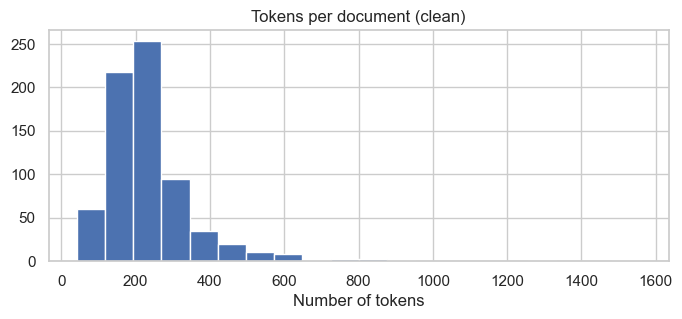


Article counts by category:
category
Polska         252
Technologie    120
Biznes         109
Świat           95
Sport           86
Moto            50
Name: count, dtype: int64
Updated dataset with cleaned text_norm saved to polsatnews_articles_clean_topics.csv


In [ ]:
import numpy as np

def clean_tokens(tokens, stopwords_set=None, min_len=3):
    out = []
    for t in tokens:
        if not t:
            continue
        if len(t) < min_len:
            continue
        if any(ch.isdigit() for ch in t):
            continue
        if not any(ch.isalpha() for ch in t):
            continue
        if stopwords_set and t in stopwords_set:
            continue
        out.append(t)
    return out

if 'df_clean' in globals():
    df_clean['tokens_clean'] = df_clean['tokens'].apply(lambda t: clean_tokens(t, stopwords_set=normalized_stop_words, min_len=3))
    df_clean['n_tokens_clean'] = df_clean['tokens_clean'].apply(len)
    print('Tokens cleaned - avg tokens per doc:', df_clean['n_tokens_clean'].mean())
else:
    print('No df_clean to clean')

if 'df_clean' in globals() and not df_clean.empty:
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set(style='whitegrid')
    plt.figure(figsize=(8,3))
    df_clean['n_tokens_clean'].hist(bins=20)
    plt.title('Tokens per document (clean)')
    plt.xlabel('Number of tokens')
    plt.show()

    print('\nArticle counts by category:')
    print(df_clean['category'].value_counts())

if 'df_clean' in globals() and not df_clean.empty:
    df_clean['text_norm_clean'] = df_clean['tokens_clean'].apply(lambda ts: ' '.join(ts))
    df_clean.to_csv('polsatnews_articles_clean_topics.csv', index=False)
    print('Updated dataset with cleaned text_norm saved to polsatnews_articles_clean_topics.csv')